<a href="https://colab.research.google.com/github/mufqam/rifqiprogress/blob/mufqam/Indonesian_Text_Sentiment_Analysis_Analisis_Sentimen_Teks_Bahasa_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indonesian Text Sentiment Analysis/Analisis Sentimen Teks Bahasa Indonesia
30 Aug 2021

Project ini menggunakan bahasa pemrograman Python dan memanfaatkan beberapa library, antara lain:

**Untuk membaca dan memproses file PDF:**

*   PyPDF2

**Untuk machine learning dan analisis data:**

*   scikit-learn (dengan CountVectorizer dan LogisticRegression)
*   pandas
*   NumPy

**Untuk pemrosesan bahasa alami (NLP):**

*   NLTK
*   spaCy

**Untuk membuat antarmuka pengguna:**

*  Gradio


# Import Libraries

In [ ]:
!pip install -q PyPDF2  # PyPDF untuk membaca file pdf
!pip -q install gradio  # Gradio ML untuk membuat interface
!pip -q install -U spacy   # spaCy

!python -m spacy download en_core_web_sm # Pretrained model dari spaCy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 3.4 MB 7.9 MB/s 
     |████████████████████████████████| 1.9 MB 45.7 MB/s 
     |████████████████████████████████| 206 kB 77.4 MB/s 
     |████████████████████████████████| 3.2 MB 63.7 MB/s 
     |████████████████████████████████| 63 kB 2.9 MB/s 
     |████████████████████████████████| 961 kB 60.5 MB/s 
     |████████████████████████████████| 5.8 MB 8.8 MB/s 
     |████████████████████████████████| 10.1 MB 24.4 MB/s 
     |████████████████████████████████| 456 kB 37.2 MB/s 
     |████████████████████████████████| 621 kB 74.7 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 13.6 MB 75 kB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package vi

In [ ]:
# Standard Library
import string
import re

# Pdf Reader
import PyPDF2

# Common Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Deep Learning
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# NLP
import nltk
from nltk.corpus import stopwords
# Beberapa fungsi dalam nltk membutuhkan file ini
nltk.download("punkt")
nltk.download("stopwords")

import spacy
from spacy import displacy

# User Interface
import gradio as gr

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Download Data

In [ ]:
# Bash command untuk mendownload file PDF
!wget -q https://www.mkri.id/public/content/infoumum/regulation/pdf/UUD45%20ASLI.pdf

In [ ]:
# Download data untuk machine learning
!git clone https://github.com/rakkaalhazimi/Data-NLP-Bahasa-Indonesia

Cloning into 'Data-NLP-Bahasa-Indonesia'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


# 1 - Analisis Konteks menggunakan NLTK

## Baca file pdf

In [ ]:
pdf = open("UUD45 ASLI.pdf", "rb")
pdf_reader = PyPDF2.PdfFileReader(pdf)

## Ekstrak teks dalam pdf

In [ ]:
# Ambil teks di tiap halaman pdf
def get_pdf_text(pdf):
    return "\n".join(page.extractText() for page in pdf.pages)

uud45 = get_pdf_text(pdf_reader)

In [ ]:
# Rapikan teks dengan regular expression
def format_linespace(text):
    text = re.sub(r"(\w)(\n)(\w)", r"\1\3", text) # menghilangkan baris diantara kata
    text = re.sub(r"(\n)(-)(\n)", r"\2", text)    # menghilangkan baris diantara tanda "-"
    return text

uud45_clean = format_linespace(uud45)
print(uud45_clean[:100])

 
 
UNDANG-UNDANG DASAR 
NEGARA
 
REPUBLIK INDONESIA 
 
1945
 
 
Pembukaan
 
Bahwa sesungguhnya keme


## Tokenisasi
Ubah teks menjadi kumpulan kata

In [ ]:
# .lower() supaya teks jadi lowercase
uud45_tokens = nltk.tokenize.word_tokenize( uud45_clean.lower() )

# Filter tanda baca dengan list comprehension
# ambil semua kata yang termasuk alpanumerik .isalnum()
uud45_tokens = [word for word in uud45_tokens if word.isalnum()]
uud45_tokens[:10]

['dasar',
 'negara',
 'republik',
 'indonesia',
 '1945',
 'pembukaan',
 'bahwa',
 'sesungguhnya',
 'kemerdekaan',
 'itu']

## Wrapper NLTK untuk melakukan analisis konteks

Data teks yang sebelumnya sudah di tokenisasi dapat dijadikan argumen untuk membuat instance dalam wrapper nltk.text.Text().

Wrapper ini dapat kita pakai untuk melakukan beragam analisis konteks dalam teks.

Macam-macam analisis dapat berupa:

- Common Contexts: Konteks yang dipakai suatu kata.
- Similar : Kata dengan konteks yang mirip.
- Collocation: Kata-kata yang sering muncul bersamaan.
- dll.


In [ ]:
# Masukkan kumpulan kata tadi kedalam wrapper nltk.text.Text
# Wrapper ini digunakan untuk melakukan eksplorasi pada tokens
# yang dimasukkan.
uud45_nltk = nltk.text.Text(uud45_tokens)
uud45_nltk

<Text: dasar negara republik indonesia 1945 pembukaan bahwa sesungguhnya...>

## Common Contexts: Konteks yang dipakai suatu kata

In [ ]:
# Mencari konteks suatu kata
uud45_nltk.common_contexts(["negara"])

dasar_republik kemerdekaan_indonesia pemerintah_indonesia
dasar_indonesia susunan_republik 1_indonesia ialah_kesatuan ibukota_3
haluan_bab pemerintah_pasal dengan_lain duta_lain kementerian_pasal
oleh_2 pemerintahan_dan keperluan_berdasarkan keuangan_selanjutnya
keuangan_diadakan warga_pasal warga_ialah


## Similar: Kata dengan konteks yang mirip

In [ ]:
# Mencari kata dengan konteks yang mirip
uud45_nltk.similar("negara")

daerah dasar indonesia bangsa dan sebab karena rakyat kebangsaan dalam
kemanusiaan kekuasaan presiden keadaan persidangan kebudayaan
masyarakat sedangkan lingkungannya


## Concordance: Kemunculan kata beserta konteksnya

In [ ]:
# Pencarian kata beserta konteksnya
uud45_nltk.concordance("negara")

Displaying 25 of 121 matches:
                                    negara republik indonesia 1945 pembukaan b
 ke depan pintu gerbang kemerdekaan negara indonesia yang merdeka bersatu berd
tu untuk membentuk suatu pemerintah negara indonesia yang melindungi segenap b
aan indonesia itu dalam suatu dasar negara indonesia yang terbentuk dalam suat
 yang terbentuk dalam suatu susunan negara republik indonesia yang berkedaulat
b i bentuk dan kedaulatan pasal 1 1 negara indonesia ialah negara kesatuan yan
an pasal 1 1 negara indonesia ialah negara kesatuan yang berbentuk republik 2 
 sekali dalam lima tahun di ibukota negara 3 segala putusan majelis permusyawa
kan dasar dan besar dari ada haluan negara bab iii kekuasaan pemerintah negara
negara bab iii kekuasaan pemerintah negara pasal 4 1 presiden republik indones
at perdamaian dan perjanjian dengan negara lain pasal 12 presiden menyatakan k
dan konsul 2 presiden menerima duta negara lain pasal 14 presiden memberi gras
kepada pemerintah bab 

## Collocations: Kata-kata yang sering muncul bersamaan

In [ ]:
# Mencari dua kata yang sering muncul bersama
uud45_nltk.collocations()

dewan perwakilan; perwakilan rakyat; majelis permusyawaratan;
permusyawaratan rakyat; berdasar atas; ditetapkan dengan; oleh karena;
republik indonesia; telah jelas; wakil presiden; warga negara;
keadilan sosial; persetujuan dewan; maha esa; pertimbangan agung; akan
tetapi; hanya memuat; berhubung dengan; dari pada; bertanggung jawab


## Lexical Dispersion plot: Sebaran kata dalam teks/dokumen

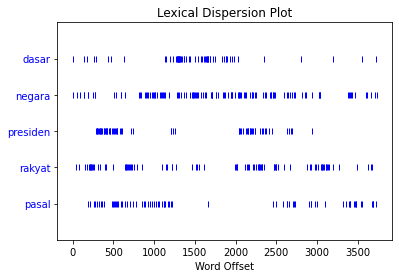

In [ ]:
# Mencari tahu sebaran kata dalam teks.
# Tiap garis menggambarkan kata
# Tiap baris menggambarkan keseluruhan kata (dari awal sampai akhir)
uud45_nltk.dispersion_plot(["dasar", "negara", "presiden", "rakyat", "pasal"])

## Frekuensi Kata

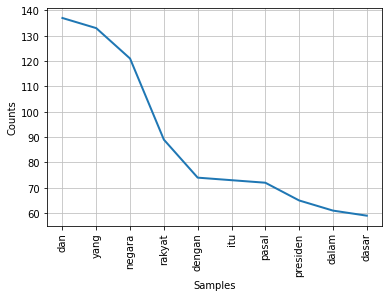

In [ ]:
# UUD45 sebelum amandemen
uud45_freq = nltk.FreqDist(uud45_tokens)
# Tampilkan 10 kata teratas yang sering digunakan.
uud45_freq.plot(10)

# 2 - Analisis Sentimen dengan Scikit-Learn

## Data Preparation
Persiapkan dahulu data yang akan kamu gunakan, periksa apakah terdapat null values atau tidak.

In [ ]:
review_file = "/content/Data-NLP-Bahasa-Indonesia/review_hotel.csv"

review_df = pd.read_csv(review_file)
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


Lalu, mulai dengan praproses teks untuk menyederhanakan teks supaya bisa lebih mudah untuk dipakai dalam analisis atau prediksi

In [ ]:
def text_preprocessing(text):
    # Lowercasing
    text = text.lower()

    # Punctuation Removal
    table = text.maketrans("", "", string.punctuation)
    text = text.translate(table)

    return text

In [ ]:
review_df["preprocessed_text"] = review_df["review_text"].map(text_preprocessing)

In [ ]:
review_df.head(5)

,review_id,review_text,category,preprocessed_text
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,penginapannya rapi bersih suasana tenang pelay...
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,wifi tidak sampai kamar tidak tersedia heater ...
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,lantai kamar mandi kotor bau dan seperti sdh j...
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,wc jorok kasur tidak dibersihkan handuk tidak ...
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,bocor lagi


In [ ]:
# Cek Kategori Data
review_df["category"].value_counts()

0    12839
1     2017
Name: category, dtype: int64

## Representasi Teks
Teks yang sudah bersih tadinya akan diubah ke bentuk yang bisa dicerna oleh komputer

In [ ]:
review_text = review_df["preprocessed_text"].values
vect = CountVectorizer()

# Gunakan kode ini jika ingin melakukan stopwords removal
# vect = CountVectorizer(stop_words=stops)

# Membuat BoW
vect.fit(review_text)
bow = vect.transform(review_text)

bow

<14856x16898 sparse matrix of type '<class 'numpy.int64'>'
	with 214617 stored elements in Compressed Sparse Row format>

In [ ]:
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Menentukan Input dan Output Data

In [ ]:
# Data utuh
X_full, y_full = bow, review_df["category"].values

# Data yang terpisah: train dan test
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full)

## Pemodelan Machine Learning

In [ ]:
# Fit data train ke dalam model
logres = LogisticRegression()
logres.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Cek skor akurasi
logres.score(X_test, y_test)

0.9364566505115778

Jika akurasinya bagus, maka model ini akan kita pakai dan akan kita fit dengan data yang penuh.

In [ ]:
logres.fit(X_full, y_full)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Prediksi

In [ ]:
# Prediksi review pelanggan
contoh_review = ["tempatnya kurang nyaman"]
contoh_bow = vect.transform(contoh_review)

# Akan muncul 0 jika sentimen negatif
#      muncul 1 jika sentimen positif

# Jika hasilnya kurang tepat, teman-teman bisa coba
# menggunakan stopwords dalam prosesnya.
logres.predict(contoh_bow)

array([0])

## Membuat Interface
Kita bisa membuat interface untuk aplikasi NLP dengan menggunakan Gradio ML, sebuah library untuk membuat UI yang bisa disesuaikan dengan aplikasi yang kamu buat. Gradio ML ini bisa menjalankan code machine learning kamu supaya orang lain juga bisa mencobanya.

Cek disini untuk lebih jelasnya: https://gradio.app/

In [ ]:
# Kita perlu memberikan keterangan pada label 0 dan 1
sentiment_map = {0: "Negative", 1: "Positive"}

In [ ]:
# Buat fungsi utama yang akan dijalankan
def predict_sentiment(review):

    review_cleaned = text_preprocessing(review)
    review_representation = vect.transform([review_cleaned])

    prediction = int( logres.predict(review_representation) )
    sentiment = sentiment_map.get(prediction)

    return sentiment

predict_sentiment("aku tidak suka")

'Negative'

In [ ]:
# Pembuatan Interface bisa dilakukan dengan memasukkan
# tiga keyword argumens pada class gr.Interface
# yaitu fn, inputs, dan outputs

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.inputs.Textbox(lines=2, placeholder="Your reviews about this place"),
    outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://46734.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://46734.gradio.app')

# 3 - Analisis Sentimen dengan Deep Learning
Metode deep learning merupakan versi rumit dari model machine learning biasa. Kata "Deep" disini bukan berarti

In [ ]:
# Buat variabel untuk label
category = review_df["category"]

## Tentukan Parameter

In [ ]:
max_features = 10000      # Jumlah kosakata
embedding_dim = 64        # Jumlah dimensi dalam word embedding
sequence_length = 100     # Maksimal panjang kalimat

## Ubah teks ke data timeseries/berurutan
Neural network memerlukan data yang berbentuk tensor, tensor adalah wadah untuk menyimpan data. Jika kamu kenal yang namanya matriks, maka itu adalah tensor 2 dimensi. Bisa dikatakan kalau tensor adalah bentuk umum dari matriks yang dapat terdiri dari berbagai dimensi (0, 1, 2, 3, dst.).

Disini teks akan diubah ke tensor 3D (batch, length, features), tensor 3D terbentuk dari kumpulan tensor 2D, begitu juga seterusnya.

In [ ]:
token = Tokenizer(num_words=max_features)
token.fit_on_texts(review_text)

def text_to_sequence(texts):
    # Ubah ke data berurutan
    review_sequences = token.texts_to_sequences(texts)

    # Samakan panjang kalimatnya
    review_sequences = pad_sequences(review_sequences, maxlen=sequence_length, padding="post")

    return review_sequences

review_sequences = text_to_sequence(review_text)

review_sequences # Masih (batch, length), dimensi yang terakhir nanti akan dibuat dalam proses modeling

array([[1158,  345,   13, ...,    0,    0,    0],
       [  41,    2,  112, ...,    0,    0,    0],
       [  72,    1,    8, ...,    0,    0,    0],
       ...,
       [  36,   97,   60, ...,    0,    0,    0],
       [ 449,   15,    6, ...,    0,    0,    0],
       [ 441,   15,   15, ...,    0,    0,    0]], dtype=int32)

Tips:
Pembatasan jumlah kosakata biasa dilakukan untuk menghilangkan kata-kata yang jarang dipakai.

## Membuat Model

In [ ]:
model = keras.Sequential()

# Tentukan ukuran input data
model.add( keras.Input(shape=(sequence_length,), dtype="int64") )

# Buat layer embedding untuk mengubah representasi kosakata menjadi vektor n-dimensi
model.add( keras.layers.Embedding(max_features, embedding_dim))

# Buat layer LSTM untuk mencari representasi yang berguna dalam data
# dengan mempertimbangkan urutan kata
model.add( keras.layers.LSTM(32) )

# Buat layer terakhir yang akan menentukan output dari model
model.add( keras.layers.Dense(1, activation="sigmoid") )

# Tentukan loss, optimizer dan metrik yang akan digunakan
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

In [ ]:
# Melihat arsitektur model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________


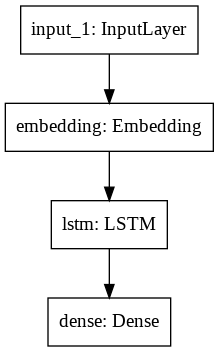

In [ ]:
# Melihat Diagram Model
keras.utils.vis_utils.plot_model(model, "model.png")

## Melatih Model

In [ ]:
model.fit(x=review_sequences,
          y=category,
          batch_size=32,
          epochs=1,
          validation_split=0.2)

372/372 [==============================] - 24s 58ms/step - loss: 0.4098 - acc: 0.8613 - val_loss: 0.3748 - val_acc: 0.8758


## Prediksi

In [ ]:
contoh_review = ["kasur belum diganti, bau sekali"]

contoh_urutan = text_to_sequence(contoh_review)

prediksi = model.predict(contoh_urutan) # Probabilitas

prediksi.squeeze()  # diatas 0.5 berarti label 1 atau sentimen negatif, begitu juga sebaliknya

array(0.12677217, dtype=float32)

# 4 - spaCy: Library NLP lanjutan untuk berbagai task NLP
spaCY menyediakan berbagai layanan text processing seperti tagging, parsing, NER, text classification dll. dengan pre-trained model yang sudah dalam tahap state of art (level tinggi).

Lebih jelasnya bisa di klik [disini](https://spacy.io/usage/linguistic-features)

## POS Tagging
Proses menandai kata dalam teks berdasarkan peran/kelas sintaktik sebuah kata dalam corpus. Biasanya, proses penandaan ini harus disesuaikan dengan definisi dan konteks dalam kalimat.



In [ ]:
nlp = spacy.load("en_core_web_sm")
doc_dep = nlp("Databangalore Bootcamp is good for learning data science in Indonesia")

displacy.render(doc_dep, style="dep", jupyter=True)

Kita lihat dalam bentuk tabel

In [ ]:
fields = ["text", "lemma", "pos", "tag", "dep", "shape", "alpha", "stop"]

with open("dep.csv", "w") as dep_csv:
    # Masukkan field/kolom dari csv
    dep_csv.write(",".join(fields) + "\n")

    # Print hasil analisis ke dalam file csv
    for token in doc_dep:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
              token.shape_, token.is_alpha, token.is_stop,
              file=dep_csv, sep=",", end="\n")

# Buka file csv yang sudah dibuat
dep_df = pd.read_csv("dep.csv")
dep_df

,text,lemma,pos,tag,dep,shape,alpha,stop
0,Databangalore,Databangalore,PROPN,NNP,compound,Xxxxx,True,False
1,Bootcamp,Bootcamp,PROPN,NNP,nsubj,Xxxxx,True,False
2,is,be,AUX,VBZ,ROOT,xx,True,True
3,good,good,ADJ,JJ,acomp,xxxx,True,False
4,for,for,ADP,IN,prep,xxx,True,True
5,learning,learn,VERB,VBG,pcomp,xxxx,True,False
6,data,data,NOUN,NN,compound,xxxx,True,False
7,science,science,NOUN,NN,dobj,xxxx,True,False
8,in,in,ADP,IN,prep,xx,True,True
9,Indonesia,Indonesia,PROPN,NNP,pobj,Xxxxx,True,False


## Lemmatization
Mengubah kata ke bentuk dasar

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Untuk mengecek tipe lemmatizer yang dipakai
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode) # rule-based lemmatizer

doc = nlp("I was reading the paper.")
print([token.lemma_ for token in doc])

rule
['I', 'be', 'read', 'the', 'paper', '.']


## Named-Entity-Recognition
NER merupakan task untuk mencari dan mengkategorikan entitas yang bernama dalam sebuah teks ke dalam berbagai kategori seperti nama orang, organisasi, nama lokasi, persentasi, tanggal dll.

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc_ent = nlp("President of Indonesia, Ir. Joko Widodo, will announce an important information in Istana Merdeka pada tahun jam 17:00")

displacy.render(doc, style="ent", jupyter=True)

Kita lihat dalam bentuk tabel

In [ ]:
fields = ["text", "start", "end", "label"]

with open("ent.csv", "w") as ent_csv:
    # Masukkan field/kolom dari csv
    ent_csv.write(",".join(fields) + "\n")

    # Print hasil analisis ke dalam file csv
    for ent in doc_ent.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_,
              file=ent_csv, sep=",", end="\n")

# Buka file csv yang sudah dibuat
ent_df = pd.read_csv("ent.csv")
ent_df

,text,start,end,label
0,Indonesia,13,22,GPE
1,Joko Widodo,28,39,PERSON
2,Istana Merdeka,83,97,GPE
3,17:00,113,118,TIME


## Word vectors Similarity
spaCy sudah memiliki representasi vektor untuk setiap kata yang ada dalam korpusnya. Vektor tersebut bisa kita pakai untuk mencari kata dengan arti yang mirip.

Mengetahui vektor dalam kata

In [ ]:
nlp = spacy.load("en_core_web_md")
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 7.0336733 False
cat True 6.6808186 False
banana True 6.700014 False
afskfsd False 0.0 True


Mencari tingkat kemiripan antar kata

In [ ]:
print("{} <-> {} : {}".format(
    tokens[0], tokens[1], tokens[0].similarity(tokens[1])))

dog <-> cat : 0.8016854524612427


Mencari tingkat kemiripan antar kalimat

In [ ]:
doc1 = nlp("Data science is an interdisciplinary field that uses scientific methods,"
           "processes, algorithms and systems to extract knowledge and insights from"
           "structured and unstructured data, and apply knowledge and actionable"
           "insights from data across a broad range of application domains. Data science"
           "is related to data mining, machine learning and big data.")

doc2 = nlp("Data science is the field of study that combines domain expertise,"
            "programming skills, and knowledge of mathematics and statistics to "
            "extract meaningful insights from data.")

print("Similarity Rate: {}".format(doc1.similarity(doc2)))

Similarity Rate: 0.9679645334572656
